# 目录
1. [分类决策树 Python 实现](#1)<br> 
&emsp;&emsp;1.1 [定义决策树节点](#1.1)<br>
&emsp;&emsp;1.2 [基尼系数计算](#1.2)<br> 
&emsp;&emsp;1.3 [分类决策树生成](#1.3)<br>
&emsp;&emsp;1.4 [使用 Networkx 将决策树可视化](#1.4)<br> 
&emsp;&emsp;1.5 [决策树的决策边界](#1.5)<br>
&emsp;&emsp;1.6 [实现决策树的预测函数](#1.6)<br> 
2. [回归决策树 Python 实现](#2)<br> 
&emsp;&emsp;2.1 [回归树节点实现](#2.1)<br>
&emsp;&emsp;2.2 [回归决策树生成](#2.2)<br> 
&emsp;&emsp;2.3 [在鲍鱼数据集上测试回归效果](#2.3)<br> 
3. [实现随机森林算法](#3)<br> 
4. [实现 AdaBoost 算法](#4)<br> 
5. [基于树模型的个人信用风险评估](#5)<br> 
6. [总结](#6)<br> 


# <a id=1></a>1 分类决策树 Python 实现
我们首先加载一份鸢尾花数据集以便于测试。鸢尾花数据集包含 150 个鸢尾花样本，每个样本包含 4 个特征和一个类别标签，数据集下载地址为 [UCI鸢尾花](http://archive.ics.uci.edu/ml/datasets/Iris)。在 `Sklearn` 中可以使用 `datasets.load_iris` 方法直接加载该数据集。

 <img src="http://cookdata.cn/media/casestudy/29/IrisEx.png" width = "400" height = "400"/>

In [24]:
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data,columns=iris.feature_names)
iris_df["target"] = iris.target
iris_df.head()
iris_df.columns = ["sepal_len","sepal_width","petal_len","petal_width","target"]
X_iris = iris_df.iloc[:,:-1]
y_iris = iris_df["target"]

In [25]:
iris_df.head()

,sepal_len,sepal_width,petal_len,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


下面我们开始实现 CART 决策树算法。首先，我们需要创建一个 `TreeNode` 类代表决策树的节点。CART 使用基尼系数 (Gini index) 作为不纯度度量，我们随后将实现一个 `gini` 函数来计算基尼系数。完成节点的定义和基尼系数的计算，我们就可以开始实现决策树的生成算法。为了直观地展示学习到的决策树的结构，我们将借助 Matplotlib 和 Networkx 实现决策树的可视化。

## <a id=1.1></a>1.1 定义决策树节点
创建一个表示决策树节点的类 `TreeNode`。决策树节点需要存储的最重要的信息为当前节点代表的特征 `f` 和切分点 `v` 。其次如果节点是非叶子节点，还需要存储左儿子节点 `left` 和右儿子节点 `right`。为了便于决策树进行预测，我们在每个节点中还要保存当前节点样本的分布 `label_dist`，它将在决策树生成时提供。在本案例的后续，我们还将把决策树绘制出来，为了方便绘制，我们给每一个节点还保存了节点的坐标信息 `pos` ，也将在决策树生成时计算。

In [26]:
class TreeNode:
    def __init__(self,x_pos,y_pos,layer,class_labels=[0,1,2]):
        self.f = None #当前节点的切分特征
        self.v = None #当前节点的切分点
        self.left = None #左儿子节点
        self.right = None #右儿子节点
        self.pos = (x_pos,y_pos) # 节点坐标，可视化用
        self.label_dist = None #当前节点样本的类分布
        self.layer = layer
        self.class_labels = class_labels
    def __str__(self): #打印节点信息，可视化时的节点标签
        if self.f != None:
            return self.f + "\n<=" + str(round(self.v,2))
        else:
            return str(self.label_dist) + "\n(" + str(np.sum(self.label_dist)) + ")"

上面的代码中，`__str__` 函数定义调用打印函数 `print` 时输出的信息。对于非叶子节点（判断条件`self.f != None`）,打印节点的特征和切分点；对于叶子节点，打印节点训练样本的类别分布和样本数量。这些信息将在绘制决策树时作为节点的标签信息。

## <a id=1.2></a>1.2 基尼系数计算

Gini系数是一种度量落在决策树中某一个节点的样本分布不纯度的指标。假设数据集中样本一共有 $C$ 个类别，在节点 $t$ 中第 $c$ 类样本的比例为 $p_{t,c}$，则节点 $t$ 的不纯度为
$$
\text{Gini}(t) = 1 - \sum_{c=1}^C p^2_{t,c}
$$
假设样本的类别为正负两类，假设某个节点一共有 10 个样本，包括 5 个正样本和 5 个负样本，则基尼系数为 
$$1 - \left(\frac{5}{10}\right)^2 - \left(\frac{5}{10}\right)^2 = \frac{1}{2}$$
假设另一个节点有 20 个样本，包含 15 个正样本和 5 个负样本，则基尼系数为 

$$1 - \left(\frac{15}{20}\right)^2 - \left(\frac{5}{20}\right)^2 = \frac{3}{8}$$

实现一个不纯度计算方法 `gini` ,它的输入是当前节点样本的标签序列 $y$。 $y$ 是 Pandas 的 `Series` 结构。我们使用 `value_counts` 方法计算每一类样本的数量，然后借助 `np.square` 和 `sum` 函数计算其平方和。

In [27]:
import numpy as np
def gini(y):
    return  1 - np.square(y.value_counts()/len(y)).sum()

下图详细演示了基尼系数的计算过程。

<img src="http://cookdata.cn/media/note_images/基尼系数的计算过程_1591179228497_5d14.jpg" width = "675" height = "263"/>

In [28]:
import pandas as pd
gini(pd.Series([1,1,-1,-1,1]))

0.48

## <a id=1.3></a>1.3 分类决策树生成

实现 `generate` 函数，输入数据子集，输出创建好的节点。其中 `X` 和 `y` 分别为训练集特征部分和标签部分，是该函数的主要输入，其余的输入参数为一些辅助参数，其主要含义如下表所示。

|输入参数|含义说明|
|:----|:----|
|`X`|数据子集特征部分，格式为 `DataFrame`|
|`y`|数据子集特征部分，格式为 `Series`|
|`x_pos`|节点x轴坐标|
|`y_pos`|节点y轴坐标|
|`nodes`|用户保存决策树中所有节点的列表|
|`min_leaf_samples`|叶子节点最少样本数量|
|`max_depth`|决策树最大深度|
|`layer`|当前节点的层数，等于该节点父节点层数加1|
|`class_labels`|样本的标签集合，格式为 `Series`|

决策树生成函数 `generate` 的主要流程为：

+ 1 创建当前节点 `current_node` ,计算其样本分布 `label_dist`

+ 2 if 当前样本数量太少，决策树层数超过最大深度或者节点的基尼系数小于某个阈值

 + 节点不再分裂，返回 `current_node`

+ 3 else 

 + 3.1 遍历所有候选特征和切分点对 $(f,v)$ ,计算其基尼系数，找出最佳的分裂特征和切分点 $(best\_f,best\_v)$
 
 + 3.2 根据 $(best\_f,best\_v)$ 将数据子集分为两个子集 $(X1,y1)$ 和 $(X2,y2)$
 
 + 3.3 使用 $(X1,y1)$  调用 `generate` 函数创建 `current_node` 的左儿子节点
 
 + 3.3 使用 $(X2,y2)$ 调用 `generate` 函数创建 `current_node` 的左儿子节点

+ 4 返回当前节点 `current_node`

In [29]:
def generate(X,y,x_pos,y_pos,nodes,min_leaf_samples,max_depth,layer,class_labels):
    current_node = TreeNode(x_pos,y_pos,layer,class_labels)#创建节点对象
    current_node.label_dist = [len(y[y==v]) for v in class_labels] #当前节点类样本分布
    nodes.append(current_node)
    if(len(X) < min_leaf_samples or gini(y) < 0.1 or layer > max_depth): #判断是否需要生成子节点
        return current_node
    max_gini,best_f,best_v = 0,None,None 
    for f in X.columns: #特征遍历
        for v in X[f].unique(): #取值遍历
            y1,y2 = y[X[f] <= v],y[X[f] > v]
            if (len(y1) >= min_leaf_samples and len(y2) >= min_leaf_samples):
                imp_descent = gini(y) - gini(y1)*len(y1)/len(y) - gini(y2)*len(y2)/len(y) # 计算不纯度变化
                if imp_descent > max_gini:
                    max_gini,best_f,best_v = imp_descent,f,v
    current_node.f,current_node.v = best_f,best_v
    if(current_node.f != None):
        current_node.left = generate(X[X[best_f] <= best_v],y[X[best_f] <= best_v],x_pos-(2**(max_depth-layer)),y_pos -1,nodes,min_leaf_samples,max_depth,layer + 1,class_labels)
        current_node.right = generate(X[X[best_f] > best_v],y[X[best_f] > best_v],x_pos+ (2**(max_depth-layer)),y_pos -1,nodes,min_leaf_samples,max_depth,layer + 1,class_labels)
    return current_node

为了后续使用方便，我们创建一个封装函数 `decision_tree_classifier`，其输入为训练数据，叶子节点最小样本数和树的最大深度。返回树的根，节点集合。

In [30]:
def decision_tree_classifier(X,y,min_leaf_samples,max_depth):
    nodes = []
    root = generate(X,y,0,0,nodes,min_leaf_samples=min_leaf_samples,max_depth=max_depth,layer=1,class_labels=y.unique())
    return root,nodes

## <a id=1.4></a>1.4 使用 Networkx 将决策树可视化

[Networkx](http://networkx.github.io/) 是一个 Python 中流行的网络分析工具，实现了网络的可视化函数。我们将使用该工具的 `draw_networkx` 函数对生成的决策树进行可视化。`draw_networkx` 函数需要输入 Networkx 中的网络对象，节点坐标，节点颜色，节点大小等参数,列举如下表所示。

|参数|含义说明|
|:----|:----|
|`G`|Networkx网络对象|
|`pos`|指定节点坐标的字典对象，键为节点，值为坐标(x,y)|
|`ax`|Matplotlib Axes对象，将网络绘制在该子图上|
|`node_shape`|节点形状，常见的有圆形("o")，方形（"s"），上三角形("^")等|
|`font_color`|节点标签字体颜色|
|`node_size`|节点大小|
|`node_color`|节点颜色|

编写一个函数，将训练得到的决策树转换成 Networkx 中的网络对象 `G`。

In [31]:
def get_networkx_graph(G, root):
    if root.left != None:
        G.add_edge(root, root.left) #在当前节点和左儿子节点之间建立一条边，加入G
        get_networkx_graph(G, root.left) #对左儿子执行同样操作
    if root.right != None:
        G.add_edge(root, root.right) #在当前节点和左儿子节点之间建立一条边，加入G
        get_networkx_graph(G,root.right)#对右儿子执行同样操作 

在决策树生成函数中，已经计算了节点的坐标。现在我们实现一个函数，输入节点集合，返回其位置布局字典对象。

In [32]:
def get_tree_pos(G):
    pos = {}
    for node in G.nodes:
        pos[node] = node.pos
    return pos

在决策树中，如果是叶子节点，则根据其预测类别显示不同颜色。如果是非叶子节点，则显示灰色。

In [33]:
def get_node_color(G):
    color_dict = []
    for node in G.nodes:
        if node.f == None:  #叶子节点
            label = np.argmax(node.label_dist)
            if label%3 == 0:
                color_dict.append("#007979") #深绿色
            elif label%3 == 1:
                color_dict.append("#E4007F") #洋红色
            else:
                color_dict.append("blue") 
        else:
            color_dict.append("gray")
    return color_dict

在鸢尾花数据集上训练决策树，然后将学习到的决策树绘制出来。

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

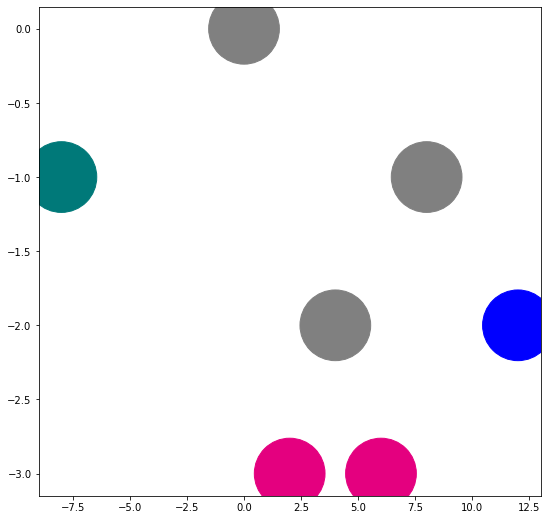

In [34]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
#1训练决策树
root,nodes = decision_tree_classifier(X_iris,y_iris,min_leaf_samples=10,max_depth=4)
#2将决策树进行可视化
fig, ax = plt.subplots(figsize=(9, 9)) #2.1将图的大小设置为 9×9
graph = nx.DiGraph() #2.2 创建 Networkx 中的网络对象
get_networkx_graph(graph, root) # 2.3 将决策树转换成 Networkx 的网络对象
pos = get_tree_pos(graph) #2.4 获取节点的坐标
# 2.5 绘制决策树
nx.draw_networkx(graph,pos = pos,ax = ax,node_shape="o",font_color="w",node_size=5000,node_color=get_node_color(graph))
plt.box(False) #去掉边框
plt.axis("off")#不显示坐标轴

In [35]:
help(plt.cbook)

Help on package matplotlib.cbook in matplotlib:

NAME
    matplotlib.cbook

DESCRIPTION
    A collection of utility functions and classes.  Originally, many
    (but not all) were from the Python Cookbook -- hence the name cbook.
    
    This module is safe to import from anywhere within Matplotlib;
    it imports Matplotlib only at runtime.

PACKAGE CONTENTS
    deprecation

CLASSES
    builtins.UserWarning(builtins.Warning)
        IgnoredKeywordWarning
    builtins.dict(builtins.object)
        maxdict
    builtins.list(builtins.object)
        silent_list
    builtins.object
        CallbackRegistry
        Grouper
        Stack
    
    class CallbackRegistry(builtins.object)
     |  CallbackRegistry(exception_handler=<function _exception_printer at 0x7faa3d4efef0>)
     |  
     |  Handle registering and disconnecting for a set of signals and callbacks:
     |  
     |      >>> def oneat(x):
     |      ...    print('eat', x)
     |      >>> def ondrink(x):
     |      ...    pr

## <a id=1.5></a>1.5 决策树的决策边界

对于二维数据，我们可以将决策树的决策边界可视化。基本想法是遍历决策树的节点，查看节点的分裂特征和切分点。如果分裂特征对应横轴，则在切分点坐标绘制一条竖线。如果分裂特征对应纵轴，则在切分点绘制一条水平线。下面，我们选取鸢尾花数据集中的 `petal_len` 和 `petal_width` 这两个特征，在二维数据集上训练决策树，然后将决策树的决策边界绘制出来。

In [36]:
import seaborn as sns
#筛选两列特征
feature_names = ["petal_len","petal_width"]
X = iris_df[feature_names]
y = iris_df["target"]
#训练决策树模型
tree_two_dimension, nodes = decision_tree_classifier(X,y,min_leaf_samples=10,max_depth=4)

绘制决策边界。

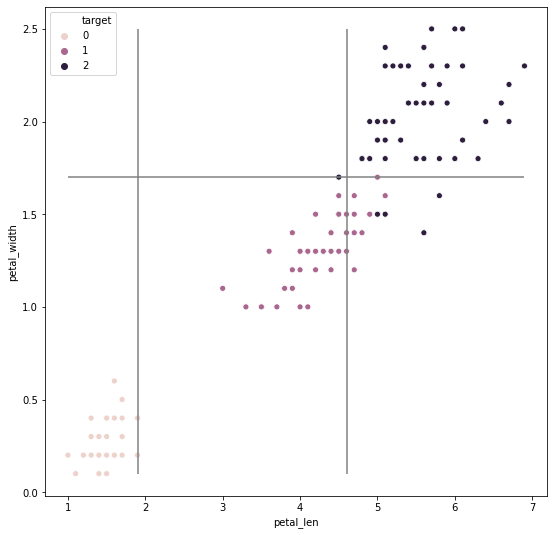

In [37]:
#开始绘制决策边界      
fig, ax = plt.subplots(figsize=(9, 9)) #设置图片大小
sns.scatterplot(x = X.iloc[:,0], y = X.iloc[:,1],ax = ax,hue = y) #绘制样本点
#遍历决策树节点，绘制划分直线
for node in nodes:
    if node.f == X.columns[0]:
        ax.vlines(node.v,X.iloc[:,1].min(),X.iloc[:,1].max(),color="gray") # 如果节点分裂特征是 petal_len ，则绘制竖线
    elif node.f == X.columns[1]:
        ax.hlines(node.v,X.iloc[:,0].min(),X.iloc[:,0].max(),color="gray") #如果节点分裂特征是 petal_width ，则绘制水平线

同样，为了方便，我们将边界绘制代码封装为一个函数 `plot_tree_boundary` 。

In [39]:
def plot_tree_boundary(X,y,tree,nodes):
    #优化计算每个决策线段的起始点
    for node in nodes:
        node.x0_min,node.x0_max,node.x1_min,node.x1_max = X.iloc[:,0].min(),X.iloc[:,0].max(),X.iloc[:,1].min(),X.iloc[:,1].max(),
    node_list = []
    node_list.append(tree)
    
    while(len(node_list)> 0):
        node = node_list.pop()
        if node.f != None:
            node_list.append(node.left)
            node_list.append(node.right)
        if node.f == X.columns[0]:
            node.left.x0_max = node.v
            node.right.x0_min = node.v
        elif  node.f == X.columns[1]:
            node.left.x1_max = node.v
            node.right.x1_min = node.v    
            
    fig, ax = plt.subplots(figsize=(9, 9)) #设置图片大小
    sns.scatterplot(x = X.iloc[:,0], y = X.iloc[:,1],ax = ax,hue = y) #绘制样本点
    #遍历决策树节点，绘制划分直线
    for node in nodes:
        if node.f == X.columns[0]:
            ax.vlines(node.v,node.x1_min,node.x1_max,color="gray") # 如果是节点分裂特征是 petal_len ，则绘制竖线
        elif node.f == X.columns[1]:
            ax.hlines(node.v,node.x0_min,node.x0_max,color="gray") #如果是节点分裂特征是 petal_width ，则绘制水平线  
    
    #绘制边框
    ax.vlines(X.iloc[:,0].min(),X.iloc[:,1].min(),X.iloc[:,1].max(),color="gray")
    ax.vlines(X.iloc[:,0].max(),X.iloc[:,1].min(),X.iloc[:,1].max(),color="gray")
    ax.hlines(X.iloc[:,1].min(),X.iloc[:,0].min(),X.iloc[:,0].max(),color="gray")
    ax.hlines(X.iloc[:,1].max(),X.iloc[:,0].min(),X.iloc[:,0].max(),color="gray")

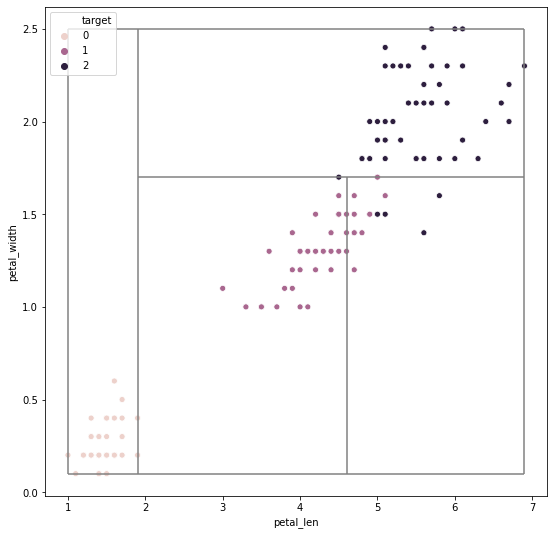

In [40]:
plot_tree_boundary(X,y,tree_two_dimension,nodes)

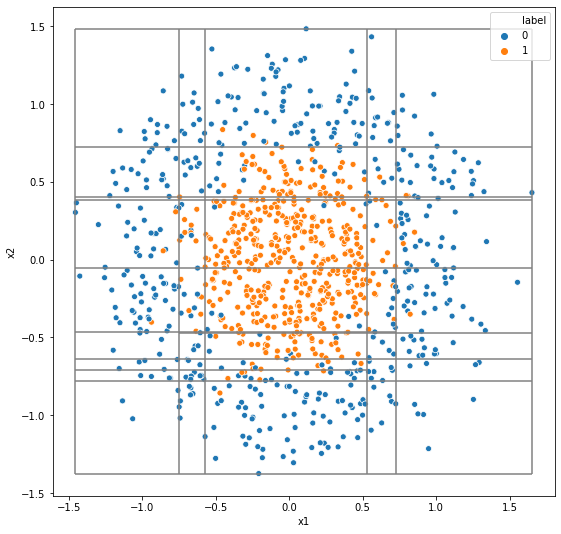

In [41]:
from sklearn import datasets
# 生成环形图，factor 控制两个环的距离
sample,target = datasets.make_circles(n_samples=1000,shuffle=True,noise=0.2,random_state=0,factor=0.4)
data = pd.DataFrame(data=sample,columns=["x1","x2"])
data["label"] = target

tree_two_dimension,nodes2 = decision_tree_classifier(data[["x1","x2"]],data["label"],min_leaf_samples=10,max_depth=5)
plot_tree_boundary(data[["x1","x2"]],data["label"],tree_two_dimension,nodes2)

生成一份随机分类数据集，查看决策树边界。

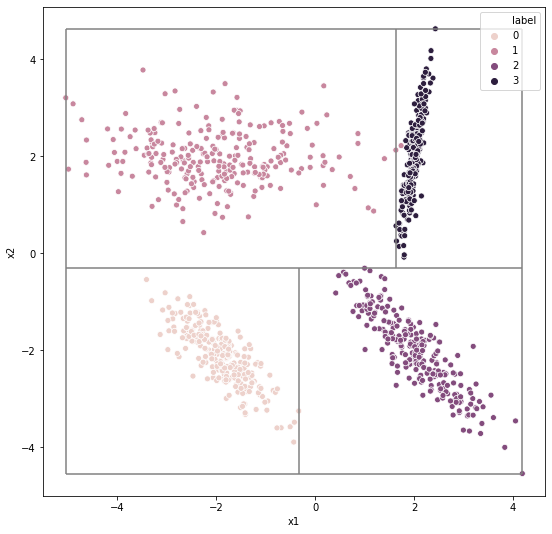

In [42]:
from sklearn import datasets
sample,target = datasets.make_classification(n_samples=1000, #样本数量
                                              n_classes=4, #类别数量
                                              n_features=2, #特征数量
                                              n_informative=2,#有信息特征数量
                                              n_redundant=0, #冗余特征数量
                                              n_repeated=0, # 重复特征数量
                                              n_clusters_per_class=1, #每一类的簇数
                                              flip_y=0, # 样本标签随机分配的比例
                                              class_sep=2,#不同类别样本的分散程度
                                              random_state=203)
data = pd.DataFrame(data=sample,columns=["x1","x2"])
data["label"] = target
tree_two_dimension,nodes2 = decision_tree_classifier(data[["x1","x2"]],data["label"],min_leaf_samples=10,max_depth=5)
plot_tree_boundary(data[["x1","x2"]],data["label"],tree_two_dimension,nodes2)

## <a id=1.6></a> 1.6 实现决策树的预测函数

训练得到一个决策树，新到一个样本后，对样本的标签进行预测。我们需要给 `TreeNode` 类添加一个 `predict` 方法。如果当前节点是叶子节点，则直接预测最多的类标签。如果当前节点是内部节点，则根据当前样本在节点特征上的取值情况，调用左儿子节点或右儿子节点的 `predict` 方法。

In [43]:
class TreeNode:
    def __init__(self,x_pos,y_pos,layer,class_labels=[0,1,2]):
        self.f = None #当前节点的切分特征
        self.v = None #当前节点的切分点
        self.left = None #左儿子节点
        self.right = None #右儿子节点
        self.pos = (x_pos,y_pos) # 节点坐标，可视化用
        self.label_dist = None #当前节点样本的类分布
        self.layer = layer
        self.class_labels = class_labels
    def __str__(self): #打印节点信息，可视化时的节点标签
        if self.f != None:
            return self.f + "\n<=" + str(self.v)
        else:
            return str(self.label_dist) + "\n(" + str(round(np.sum(self.label_dist),2)) + ")"
    #对测试样本进行预测
    def predict(self,x):
        if self.f == None:
            return self.class_labels[np.argmax(self.label_dist)]
        elif x[self.f] <= self.v:
            return self.left.predict(x)
        else:
            return self.right.predict(x)

再次训练决策树模型。

In [45]:
tree,tree_nodes = decision_tree_classifier(X_iris,y_iris,min_leaf_samples=10,max_depth=4)

选取样本进行测试。

In [47]:
sample = iris_df.iloc[77,:]
y_pred = tree.predict(sample)
print(y_pred,sample["target"])

1 1.0


In [48]:
y_pred = []
for _,sample in iris_df.iterrows():
    y_pred.append(tree.predict(sample))
y_pred[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Text(0.5, 1.0, '混淆矩阵热力图')

/Users/limuyuan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 39044 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/limuyuan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/limuyuan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/limuyuan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/limuyuan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/limuyuan/opt/anaconda3/lib/python3.7/site-p

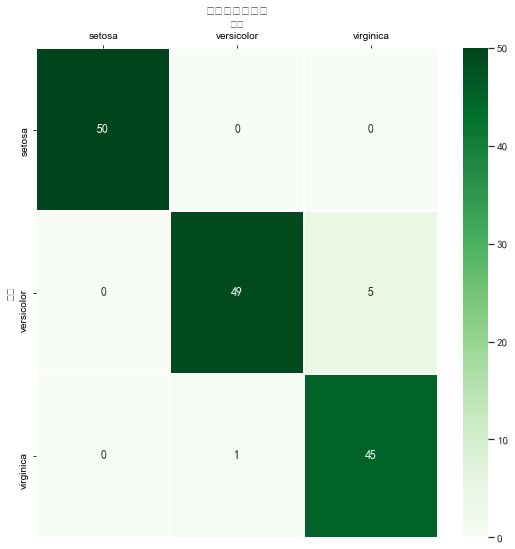

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,9))
# 设置正常显示中文
sns.set(font='SimHei')
# 绘制热力图
confusion_matrix = confusion_matrix(y_pred,iris_df["target"])#计算混淆矩阵

ax = sns.heatmap(confusion_matrix,linewidths=.5,cmap="Greens",
                 annot=True, fmt='d',xticklabels=iris.target_names, yticklabels=iris.target_names)
ax.set_ylabel('真实')
ax.set_xlabel('预测')
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.set_title('混淆矩阵热力图')

# <a id=2></a>2 回归决策树 Python 实现
对于回归问题，不纯度的度量是均方误差。模型的预测是对应叶子节点的均值。

## <a id=2.1></a>2.1 回归树节点实现

## <a id=2.1></a>2.1 回归树节点实现

修改树节点类，与分类决策树的节点中存储不同类样本数量不同的是，在回归决策树的节点中，我们需要保存该节点样本的目标值的均值。在预测方法中，如果当前节点是叶子节点，则直接输出均值进行预测。

In [52]:
class TreeNodeRegression:
    def __init__(self,y_mean,num_samples,x_pos,y_pos,layer):
        self.f = None #当前节点的切分特征
        self.v = None #当前节点的切分点
        self.left = None #左儿子节点
        self.right = None #右儿子节点
        self.pos = (x_pos,y_pos) # 节点坐标，可视化用
        self.y_mean = y_mean #节点样本均值
        self.num_samples = num_samples #节点的样本数
        self.layer = layer
    def __str__(self): #打印节点信息，可视化时的节点标签
        if self.f != None:
            return self.f + "\n<=" + str(round(self.v,2))
        else:
            return str(round(self.y_mean,2)) + "\n(" + str(self.num_samples) + ")" #修改2********************#
    #对测试样本进行预测
    def predict(self,x):
        if self.f == None:
            return self.y_mean #修改3********************#
        elif x[self.f] <= self.v:
            return self.left.predict(x)
        else:
            return self.right.predict(x)

## <a id=2.2></a>2.2 回归决策树生成

在回归决策树中，不纯度的度量是均方误差。修改决策树生成函数。

In [54]:
def generate_regression(X,y,x_pos,y_pos,nodes,min_leaf_samples,max_depth,layer):
    current_node = TreeNodeRegression(np.mean(y),len(y),x_pos,y_pos,layer)#创建节点对象
    nodes.append(current_node)
    if(len(X) < min_leaf_samples): #判断是否需要生成子节点
        return current_node
    min_square,best_f,best_v = 10e10,None,None #修改1******************#
    for f in X.columns: #特征遍历
        for v in X[f].unique(): #取值遍历
            y1,y2 = y[X[f] <= v],y[X[f] > v]
            #修改2******************#
            split_error = np.square(y1 - np.mean(y1)).sum()*len(y1)/len(y) +  np.square(y2 - np.mean(y2)).sum()*len(y2)/len(y) # 计算当前切分的均方误差
            if(split_error < min_square and len(y1) >= min_leaf_samples and len(y2) > min_leaf_samples and layer <= max_depth): #修改3******************#
                min_square,best_f,best_v = split_error,f,v
    current_node.f,current_node.v = best_f,best_v
    if(current_node.f != None):
        current_node.left = generate_regression(X[X[best_f] <= best_v],y[X[best_f] <= best_v],x_pos-(2**(max_depth-layer)),y_pos -1,nodes,min_leaf_samples,max_depth,layer + 1)
        current_node.right = generate_regression(X[X[best_f] > best_v],y[X[best_f] > best_v],x_pos+(2**(max_depth-layer)),y_pos -1,nodes,min_leaf_samples,max_depth,layer + 1)
    return current_node

同理，创建一个封装的决策树回归函数。

In [56]:
def decision_tree_regression(X,y,min_leaf_samples,max_depth):
    nodes = []
    root = generate_regression(X,y,0,0,nodes,min_leaf_samples=min_leaf_samples,max_depth=max_depth,layer=1)
    return root,nodes